In [2]:
%matplotlib inline
import geopandas as gpd
from shapely.geometry import *

### data is from: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london 
london = gpd.read_file('../data/London_Ward.shp')
### from the prj file: http://www.prj2epsg.org/epsg/27700
london = london.to_crs({'init': 'epsg:4277'})  
#london.plot()
london.head()
import sys
import numpy as np
import datetime
import numpy as np
import geojson
from scipy import stats

### path to data
venues = "../../../raw_data/venues/London_venues.txt"
transitions = "../../../raw_data/transitions/London_transitions.txt"

### venue ID -> coordinates for that venue
venue_id_to_coords = {}
with open(venues, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        ID = rows[0]
        coordinates = (float(rows[2]), float(rows[3]))
        venue_id_to_coords[ID] = coordinates

### venue ID -> ward that venue is in
venue_id_to_ward = {}
for venue in venue_id_to_coords: 
    coordinates = venue_id_to_coords[venue]
    latitude, longitude = coordinates
    point_of_checkin = Point(longitude, latitude) 
    
    does_contain_point = london.contains(point_of_checkin) 
    contains = does_contain_point[does_contain_point == True]     
    if len(contains) > 0:
        ward = contains.index[0] 
        venue_id_to_ward[venue] = ward
        
        
### create a map of venue (specifically, their ID) 
### to a list of *arrival* times to that venue       
venue_id_to_times = {}
with open(transitions, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        location1 = rows[0]
        time1 = rows[1]
        location2 = rows[2]
        time2 = rows[3]
        if location1 in venue_id_to_coords and location2 in venue_id_to_coords: 
            timeTravelled = int(time2) - int(time1)
            if timeTravelled > 0:
                # km / hrs
                timeTravelled = (timeTravelled / 60.0)/ 60.0 
                venue_id_to_times.setdefault(location1, [])
                time_cleaned = datetime.datetime.fromtimestamp(int(time1))
                venue_id_to_times[location1].append(time_cleaned)

### hour -> ward -> count 
hour_to_ward_to_count = {}

for x in range(0,24): 
    hour_to_ward_to_count[x] = {}

### for each venue, figure out which ward that venue    
### belongs to and keep track of the numb of checkins into that ward  
for venue_id in venue_id_to_times:
    checkins_to_a_venue = venue_id_to_times[venue_id]
    for checks in checkins_to_a_venue:
        # for now, we'll only look at weekdays 
        if checks.weekday() != 5 and checks.weekday() != 6:  
            if venue_id in venue_id_to_ward:
                ward = venue_id_to_ward[venue_id] 
                inner = hour_to_ward_to_count[checks.hour]
                inner.setdefault(ward, 0)
                inner[ward] += 1
                hour_to_ward_to_count[checks.hour] = inner
                
# we'll only look at wards that have at least 10 
# checkins during a given hour 
threshold_num_checkins = 10

# hour to ward to count of checkins into that ward 
# at that hour IFF the numb of checkins is over the 
# min threshold (N = 10)
hour_to_ward_to_count_threshold = {}

for x in range(0,24): 
    hour_to_ward_to_count_threshold[x] = {}

for hour in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count[hour]
    for ward in inner: 
        num_checkins = inner[ward]
        if num_checkins >= threshold_num_checkins:
            (hour_to_ward_to_count_threshold[hour])[ward] = num_checkins

In [3]:
hour_to_ward_to_rank = {}

for h in hour_to_ward_to_count_threshold: 
    hour_to_ward_to_rank[h] = {}
    
for h in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count_threshold[h]  
    x = inner
    rank_cells = {key: rank for rank, key in enumerate(sorted(x, key=x.get, reverse=True), 1)} 
    (hour_to_ward_to_rank[h]) = rank_cells


In [54]:
key_to_rank = {}
ward_id_of_interest = 503   
for venue_id in venue_id_to_times:
    if venue_id in venue_id_to_ward:
        ward = venue_id_to_ward[venue_id]  
        # get all checkins into that venue 
        checkins_to_a_venue = venue_id_to_times[venue_id]  
        for check in checkins_to_a_venue: 
            day_of_week = check.weekday()
            hour_of_day = check.hour
            week_number = check.isocalendar()[1]
            key = '{:02}'.format(week_number) + '{:02}'.format(day_of_week) + '{:02}'.format(hour_of_day) 
            
            if key == 0: 
                print key
            ward_to_rank = hour_to_ward_to_rank[hour_of_day]
            if ward in ward_to_rank: 
                rank = (ward_to_rank)[ward]  
                key_to_rank.setdefault(key, rank) 
                key_to_rank[day_of_week] = rank 

In [199]:
sorted(key_to_rank.keys())[7:168 + 8]

['010000',
 '010001',
 '010002',
 '010003',
 '010004',
 '010005',
 '010006',
 '010007',
 '010008',
 '010009',
 '010010',
 '010011',
 '010012',
 '010013',
 '010014',
 '010015',
 '010016',
 '010017',
 '010018',
 '010019',
 '010020',
 '010021',
 '010022',
 '010023',
 '010100',
 '010101',
 '010102',
 '010103',
 '010104',
 '010105',
 '010106',
 '010107',
 '010108',
 '010109',
 '010110',
 '010111',
 '010112',
 '010113',
 '010114',
 '010115',
 '010116',
 '010117',
 '010118',
 '010119',
 '010120',
 '010121',
 '010122',
 '010123',
 '010200',
 '010201',
 '010202',
 '010203',
 '010204',
 '010205',
 '010206',
 '010207',
 '010208',
 '010209',
 '010210',
 '010211',
 '010212',
 '010213',
 '010214',
 '010215',
 '010216',
 '010217',
 '010218',
 '010219',
 '010220',
 '010221',
 '010222',
 '010223',
 '010300',
 '010301',
 '010302',
 '010303',
 '010304',
 '010305',
 '010306',
 '010307',
 '010308',
 '010309',
 '010310',
 '010311',
 '010312',
 '010313',
 '010314',
 '010315',
 '010316',
 '010317',
 '010318',

In [286]:
percentage = 0.20

size = len(key_to_rank)
perc_of_data = 268# int(size*percentage)
x1 = np.empty(size)
y = np.empty(size)

i = 0

for key in sorted(key_to_rank.keys()):
    x1[i] = i
    y[i] = key_to_rank[key]
    i += 1

x_train = x1[0:perc_of_data]
y_train = y[0:perc_of_data]
x_valid = np.zeros(perc_of_data)
index = 0
for i in range(perc_of_data, perc_of_data + perc_of_data):
    x_valid[index] = i
    index += 1
#x_valid = [i for i in range(perc_of_data,len(x1))] # x_valid is just an index 
#x_valid = x1[perc_of_data:len(x1)]
y_valid = y[perc_of_data:perc_of_data + perc_of_data]
  
# 1. training data (splitting the data up)
# 2. change to be on a weekly basis (modify the data, not average it)

# we're building a covariance matrix that we're going to invert, bayesian rules to do predict : 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

np.random.seed(2)

# Instanciate a Gaussian Process model
kernel = ExpSineSquared(1e-2, 22)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-1)

# because of deprecation 
x_train = x_train.reshape(-1,1) 
y_train = y_train.reshape(-1,1) 
x_valid = x_valid.reshape(-1,1) 
y_valid = y_valid.reshape(-1,1) 

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_train, y_train)
y2_pred, sigma = gp.predict(x_valid, return_std=True) 


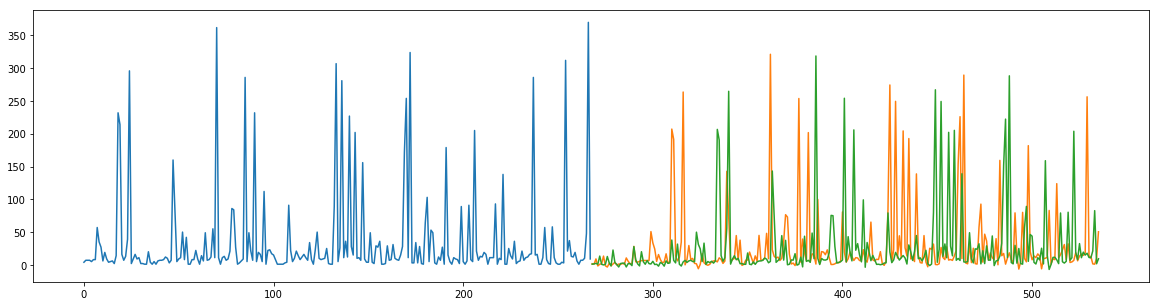

In [287]:
# Plot results
fig = plt.figure(figsize=(20, 5))
plt.plot(x_train, y_train, label='training')
#plt.plot(x_valid, y_valid, label='real')
plt.plot(x_valid, y_pred.ravel(), label='prediction')
plt.plot(x_valid, y2_pred.ravel(), label='prediction')

plt.show() 

array([ 435.])

In [209]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.datasets import fetch_mldata

data = fetch_mldata('mauna-loa-atmospheric-co2').data
X = data[:, [1]]
y = data[:, 0]

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

HTTPError: HTTP Error 500: INTERNAL SERVER ERROR